In [1]:
import os, shutil
import cv2
import zipfile

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from tqdm import tqdm

import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
def zipdir(src_path: str, zip_file: zipfile.ZipFile):
    ''' add dirctory with relative path to the zip archive

    Args:
      src_path: path to the directory
      zip_file: zip archive
    '''
    for root, dirs, files in os.walk(src_path):
        for file in files:
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, src_path)
            zip_file.write(file_path, arcname)

def archive_directory(src_dir: str, dst_file: str):
    ''' archive directory

    Args:
      src_dir: path to the directory
      dst_file: name of the archive
    '''
    with zipfile.ZipFile(dst_file, 'w', zipfile.ZIP_DEFLATED) as zipf:
        zipdir(src_dir, zipf)

In [18]:
USE_COLAB = False


MODEL_NAME = 'VGG16'
SEED = 42
image_size = (224, 224)
batch_size = 32

In [19]:
try:
    import google.colab
    from google.colab import drive
    USE_COLAB = True
except ImportError:
    USE_COLAB = False


In [20]:
dataset_dir = os.path.join('../', 'data', 'SmallPreprocessed')

if USE_COLAB:
    drive.mount('/content/drive')
    filename = 'smallpreprocessed.zip'

    dest_path = f'{filename}_extracted'
    shutil.rmtree(dest_path, ignore_errors=True)

    with zipfile.ZipFile( os.path.join('/content/drive/MyDrive', filename), 'r') as zip_ref:
        zip_ref.extractall(dest_path)


    dataset_dir = os.path.join('/content/', dest_path, 'data', 'SmallPreprocessed')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
datagen = ImageDataGenerator(
    preprocessing_function= tf.keras.applications.resnet.preprocess_input,
    rescale=1./255,
)

train_generator = datagen.flow_from_directory(
    os.path.join(dataset_dir, 'train'),
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True
)

test_generator = datagen.flow_from_directory(
    os.path.join(dataset_dir, 'test'),
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False
)

val_generator = datagen.flow_from_directory(
    os.path.join(dataset_dir, 'val'),
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True
)

Found 12000 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.


In [6]:
class_num = list(train_generator.class_indices.keys())
class_num

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [7]:
model = keras.models.Sequential()

model.add(Input(shape=(image_size[0], image_size[1], 3)))
model.add(
    tf.keras.applications.VGG16(
        include_top = False,
        pooling = 'avg',
        weights = 'imagenet'))

model.add(keras.layers.Flatten())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(2048, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(4, activation='softmax'))
model.layers[0].trainable = False

# Build the model with the correct input shape
model.build(input_shape=(None, image_size[0], image_size[1], 3))
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 512)                 │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2048)                │       1,050,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │           4,100 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,881,924 (68.21 MB)

 Trainable params: 3,160,068 (12.05 MB)

 Non-trainable params: 14,721,856 (56.16 MB)

In [8]:
checkpoint_cb = ModelCheckpoint(
    f"model_{MODEL_NAME}_checkpoint.keras",
    save_best_only = True)

early_stopping_cb = EarlyStopping(
    patience = 10,
    restore_best_weights = True
)

model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [9]:
EPOCHS = 20

In [10]:
hist = model.fit(
    train_generator,
    epochs = EPOCHS,
    validation_data = val_generator,
    callbacks = [checkpoint_cb, early_stopping_cb]
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


375/375 ━━━━━━━━━━━━━━━━━━━━ 96s 217ms/step - accuracy: 0.6440 - loss: 1.2649 - val_accuracy: 0.6460 - val_loss: 0.8381
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 74s 197ms/step - accuracy: 0.8345 - loss: 0.4407 - val_accuracy: 0.8490 - val_loss: 0.3953
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 74s 198ms/step - accuracy: 0.9010 - loss: 0.2698 - val_accuracy: 0.8955 - val_loss: 0.2692
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 74s 197ms/step - accuracy: 0.9195 - loss: 0.2235 - val_accuracy: 0.8930 - val_loss: 0.2729
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 74s 198ms/step - accuracy: 0.9334 - loss: 0.1754 - val_accuracy: 0.9165 - val_loss: 0.2418
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 84s 224ms/step - accuracy: 0.9489 - loss: 0.1445 - val_accuracy: 0.9175 - val_loss: 0.2535
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 84s 225ms/step - accuracy: 0.9483 - loss: 0.1365 - val_accuracy: 0.9155 - val_loss: 0.2808
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 75s 199ms/step - accuracy: 0.9563 - loss: 0.1220 - val

In [11]:
if USE_COLAB:
    model_dir = os.path.join('/content/', 'models')
    zip_name = os.path.join('/content/', f'{MODEL_NAME}_model.zip')
    gdrive_file = os.path.join('/content/drive/MyDrive/', f'{MODEL_NAME}_model.zip')

    os.makedirs(model_dir, exist_ok=True)

    model.save(os.path.join(model_dir, f'{MODEL_NAME}_model.keras'))
    model.export(os.path.join(model_dir, MODEL_NAME))
    archive_directory(model_dir, zip_name)

    if os.path.exists(zip_name):
        os.remove(zip_name)

    archive_directory(model_dir, zip_name)

    shutil.copyfile(zip_name, gdrive_file)

    shutil.rmtree(model_dir, ignore_errors=True)
    os.remove(zip_name)

    print(f"model data was stored on google drive as {gdrive_file}")
else:
    model.save(f'../models/{MODEL_NAME}_model.keras')
    model.export(f'../models/{MODEL_NAME}_model')

Saved artifact at '/content/models/VGG16'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  137946698502352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137946698502736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137946698508496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137946698501968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137946698500624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137946698508688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137946698500240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137946687551248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137946698500432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137946665295824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137946665

In [12]:
score, acc= model.evaluate(test_generator)
print('Val Loss =', score)
print('Val Accuracy =', acc)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 163ms/step - accuracy: 0.9600 - loss: 0.1730
Val Loss = 0.21502470970153809
Val Accuracy = 0.940500020980835


In [13]:
hist_=pd.DataFrame(hist.history)

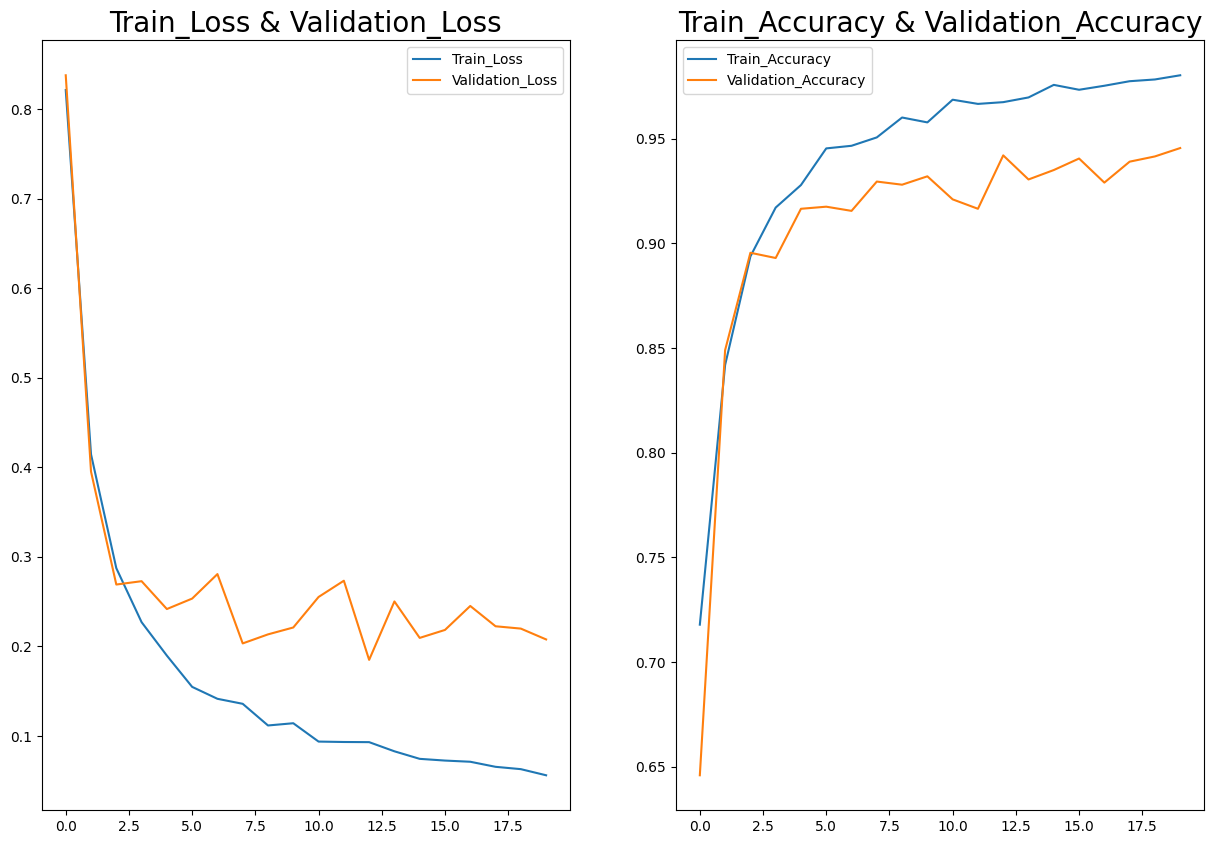

In [14]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.show()

In [15]:
y_test =test_generator.classes
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions,axis=1)
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)
df = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})

63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 178ms/step


array([[482,   7,   2,   9],
       [  1, 499,   0,   0],
       [ 10,   0, 449,  41],
       [ 17,   6,  26, 451]])

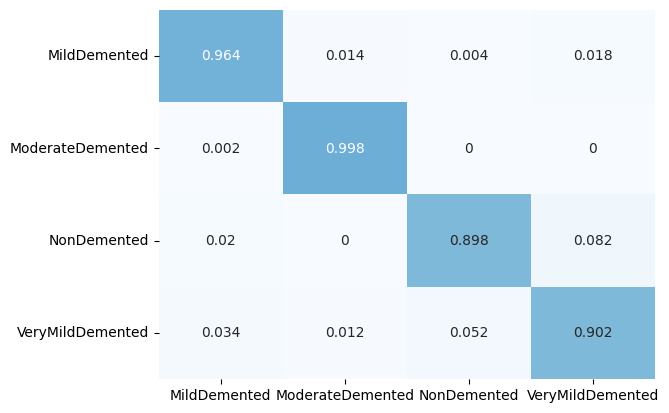

In [16]:
CM = confusion_matrix(y_test,y_pred)
CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
sns.heatmap(CM_percent,fmt='g',center = True,cbar=False,annot=True,cmap='Blues',xticklabels=class_num, yticklabels=class_num)
CM

In [17]:
ClassificationReport = classification_report(y_test,y_pred,target_names=class_num)
print('Classification Report is : ', ClassificationReport)

Classification Report is :                    precision    recall  f1-score   support

    MildDemented       0.95      0.96      0.95       500
ModerateDemented       0.97      1.00      0.99       500
     NonDemented       0.94      0.90      0.92       500
VeryMildDemented       0.90      0.90      0.90       500

        accuracy                           0.94      2000
       macro avg       0.94      0.94      0.94      2000
    weighted avg       0.94      0.94      0.94      2000

